<a href="https://colab.research.google.com/github/divyanshusharma1709/DogBB/blob/master/dogCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
from imutils import paths
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
#!pip install git+git://github.com/raghakot/keras-/vis.git --upgrade --no-deps
# Important Libraries imported

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# dataset unzipped and saved at dogDataset

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!tar -xvf /content/gdrive/My\ Drive/images.tar
!tar -xvf /content/gdrive/My\ Drive/annotation.tar

Images/
Images/n02085620-Chihuahua/
Images/n02085620-Chihuahua/n02085620_10621.jpg
Images/n02085620-Chihuahua/n02085620_10976.jpg
Images/n02085620-Chihuahua/n02085620_11238.jpg
Images/n02085620-Chihuahua/n02085620_11258.jpg
Images/n02085620-Chihuahua/n02085620_11337.jpg
Images/n02085620-Chihuahua/n02085620_1152.jpg
Images/n02085620-Chihuahua/n02085620_11696.jpg
Images/n02085620-Chihuahua/n02085620_11818.jpg
Images/n02085620-Chihuahua/n02085620_11948.jpg
Images/n02085620-Chihuahua/n02085620_1205.jpg
Images/n02085620-Chihuahua/n02085620_12334.jpg
Images/n02085620-Chihuahua/n02085620_1235.jpg
Images/n02085620-Chihuahua/n02085620_1298.jpg
Images/n02085620-Chihuahua/n02085620_13151.jpg
Images/n02085620-Chihuahua/n02085620_1321.jpg
Images/n02085620-Chihuahua/n02085620_13383.jpg
Images/n02085620-Chihuahua/n02085620_1346.jpg
Images/n02085620-Chihuahua/n02085620_14413.jpg
Images/n02085620-Chihuahua/n02085620_14516.jpg
Images/n02085620-Chihuahua/n02085620_1455.jpg
Images/n02085620-Chihuahua/n020

In [0]:
# imagePaths = list(sorted(paths.list_images("dogDataset/Images")))
# del[imagePaths[256]] #1228.xml doesn't have co-ordinates. Faulty label. Removing image and annotation from dataset
# annPaths = list(sorted(os.listdir("dogDataset/Annotation/")))
# path = "dogDataset/Annotation/"
# annPaths = [path + annPaths[i] for i in range(len(annPaths))]
# del[annPaths[256]]

# #import pickle
# #labels_norm = pickle.load(open('labels_norm_pickle.bin', 'rb'))
# # Extracting image ans annotation paths

In [5]:
ls = []
for files in os.walk("Images"):
  print(files, '\n')
  pre = files[0]
  for i in range(np.shape(files[2])[0]):
    ls.append(pre + '/' + files[2][i])

('Images', ['n02086646-Blenheim_spaniel', 'n02087046-toy_terrier', 'n02085782-Japanese_spaniel', 'n02085620-Chihuahua', 'n02088238-basset', 'n02087394-Rhodesian_ridgeback', 'n02086910-papillon', 'n02086240-Shih-Tzu', 'n02086079-Pekinese', 'n02085936-Maltese_dog', 'n02088364-beagle', 'n02088094-Afghan_hound'], []) 

('Images/n02086646-Blenheim_spaniel', [], ['n02086646_3465.jpg', 'n02086646_4219.jpg', 'n02086646_127.jpg', 'n02086646_118.jpg', 'n02086646_3766.jpg', 'n02086646_1920.jpg', 'n02086646_414.jpg', 'n02086646_3172.jpg', 'n02086646_1825.jpg', 'n02086646_2959.jpg', 'n02086646_2430.jpg', 'n02086646_117.jpg', 'n02086646_4084.jpg', 'n02086646_2069.jpg', 'n02086646_2731.jpg', 'n02086646_1621.jpg', 'n02086646_2932.jpg', 'n02086646_1023.jpg', 'n02086646_2613.jpg', 'n02086646_23.jpg', 'n02086646_2409.jpg', 'n02086646_1733.jpg', 'n02086646_801.jpg', 'n02086646_2700.jpg', 'n02086646_4026.jpg', 'n02086646_2931.jpg', 'n02086646_2366.jpg', 'n02086646_1930.jpg', 'n02086646_2641.jpg', 'n0208664

In [6]:
ls.sort()
print(ls)

['Images/n02085620-Chihuahua/n02085620_10074.jpg', 'Images/n02085620-Chihuahua/n02085620_10131.jpg', 'Images/n02085620-Chihuahua/n02085620_10621.jpg', 'Images/n02085620-Chihuahua/n02085620_1073.jpg', 'Images/n02085620-Chihuahua/n02085620_10976.jpg', 'Images/n02085620-Chihuahua/n02085620_11140.jpg', 'Images/n02085620-Chihuahua/n02085620_11238.jpg', 'Images/n02085620-Chihuahua/n02085620_11258.jpg', 'Images/n02085620-Chihuahua/n02085620_11337.jpg', 'Images/n02085620-Chihuahua/n02085620_11477.jpg', 'Images/n02085620-Chihuahua/n02085620_1152.jpg', 'Images/n02085620-Chihuahua/n02085620_11696.jpg', 'Images/n02085620-Chihuahua/n02085620_11818.jpg', 'Images/n02085620-Chihuahua/n02085620_11948.jpg', 'Images/n02085620-Chihuahua/n02085620_1205.jpg', 'Images/n02085620-Chihuahua/n02085620_12101.jpg', 'Images/n02085620-Chihuahua/n02085620_12334.jpg', 'Images/n02085620-Chihuahua/n02085620_1235.jpg', 'Images/n02085620-Chihuahua/n02085620_1271.jpg', 'Images/n02085620-Chihuahua/n02085620_12718.jpg', 'Ima

In [7]:
ann = []
for files in os.walk("Annotation"):
  print(files, '\n')
  pre = files[0]
  for i in range(np.shape(files[2])[0]):
    ann.append(pre + '/' + files[2][i])

('Annotation', ['n02086646-Blenheim_spaniel', 'n02087046-toy_terrier', 'n02085782-Japanese_spaniel', 'n02085620-Chihuahua', 'n02088238-basset', 'n02087394-Rhodesian_ridgeback', 'n02086910-papillon', 'n02086240-Shih-Tzu', 'n02086079-Pekinese', 'n02085936-Maltese_dog', 'n02088364-beagle', 'n02088094-Afghan_hound'], []) 

('Annotation/n02086646-Blenheim_spaniel', [], ['n02086646_1590', 'n02086646_3815', 'n02086646_1993', 'n02086646_981', 'n02086646_2236', 'n02086646_1936', 'n02086646_1647', 'n02086646_1002', 'n02086646_2347', 'n02086646_2805', 'n02086646_303', 'n02086646_280', 'n02086646_2959', 'n02086646_2114', 'n02086646_672', 'n02086646_4265', 'n02086646_1721', 'n02086646_2970', 'n02086646_3670', 'n02086646_45', 'n02086646_982', 'n02086646_173', 'n02086646_1094', 'n02086646_1126', 'n02086646_4024', 'n02086646_4026', 'n02086646_2252', 'n02086646_2426', 'n02086646_814', 'n02086646_23', 'n02086646_618', 'n02086646_20', 'n02086646_1586', 'n02086646_4226', 'n02086646_1091', 'n02086646_2725'

In [8]:
ann.sort()
print(ann)

['Annotation/n02085620-Chihuahua/n02085620_10074', 'Annotation/n02085620-Chihuahua/n02085620_10131', 'Annotation/n02085620-Chihuahua/n02085620_10621', 'Annotation/n02085620-Chihuahua/n02085620_1073', 'Annotation/n02085620-Chihuahua/n02085620_10976', 'Annotation/n02085620-Chihuahua/n02085620_11140', 'Annotation/n02085620-Chihuahua/n02085620_11238', 'Annotation/n02085620-Chihuahua/n02085620_11258', 'Annotation/n02085620-Chihuahua/n02085620_11337', 'Annotation/n02085620-Chihuahua/n02085620_11477', 'Annotation/n02085620-Chihuahua/n02085620_1152', 'Annotation/n02085620-Chihuahua/n02085620_11696', 'Annotation/n02085620-Chihuahua/n02085620_11818', 'Annotation/n02085620-Chihuahua/n02085620_11948', 'Annotation/n02085620-Chihuahua/n02085620_1205', 'Annotation/n02085620-Chihuahua/n02085620_12101', 'Annotation/n02085620-Chihuahua/n02085620_12334', 'Annotation/n02085620-Chihuahua/n02085620_1235', 'Annotation/n02085620-Chihuahua/n02085620_1271', 'Annotation/n02085620-Chihuahua/n02085620_12718', 'Ann

In [0]:
imagePaths = ls

In [0]:
# #Check if features and labels correspond to each other
# for i in range(len(imagePaths)):
#   im_num = (imagePaths[i].split('/')[-1]).split('.')[0]
#   lab_num = (annPaths[i].split('/')[-1]).split('.')[0]  
#   if im_num != lab_num:
#     print("Not Equal")
# print("Features and Labels Match")

In [0]:
N = 8
img_dim = 256
smooth = 0.9

In [0]:
# ##################### Test Label loader and converter #############################
# img = imagePaths[0]
# ann = annPaths[0]
# print(img, ann)
# norm_l = generateLabel(img, ann)

In [0]:
# from google.colab.patches import cv2_imshow
# im = cv2.imread(img, cv2.COLOR_BGR2RGB)
# cv2_imshow(im)
# soup = Soup(open(ann),'xml')
# xmin = (int(soup.find('bndbox').find("xmin").text))
# ymin = (int(soup.find('bndbox').find("ymin").text))
# xmax = (int(soup.find('bndbox').find("xmax").text))
# ymax = (int(soup.find('bndbox').find("ymax").text))
# cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (255, 0, 0))
# cv2_imshow(im)
# #The labels extracted are correct

In [0]:
from bs4 import BeautifulSoup as Soup
def generateLabel(img_path, ann_path):
    soup = Soup(open(ann_path),'xml')
    labels_old = []
    image = []
    labels_old.append(int(soup.find('bndbox').find("xmin").text))
    labels_old.append(int(soup.find('bndbox').find("ymin").text))
    labels_old.append(int(soup.find('bndbox').find("xmax").text))
    labels_old.append(int(soup.find('bndbox').find("ymax").text))
    # print(labels_old)
    #Normalizing this (w.r.t image dim will get rid of dim_dependence!
    image = np.array(load_img(img_path))
    #Labels_Norm = [xmin, ymin, xmax, ymax]
    labels_norm = [labels_old[0]/image.shape[1], labels_old[1]/image.shape[0], labels_old[2]/image.shape[1], labels_old[3]/image.shape[0]]
    return np.array(labels_norm)


def convertLabelDim(labels_norm, img_dim, N, i, j, smooth = 0.9):
  #bx = (real_x_mp - (x_wanted*grid_size))/grid_size
  #by = (real_y_mp - (y_wanted*grid_size))/grid_size
  #x_wanted = real_x_mp % n_partitions
  #y_wanted = real_y_mp % n_partitions
  #w = w_real/grid_size
  #b = h_real/grid_size
  prob = 0
  grid_size = img_dim/N
  labels = [x * img_dim for x in labels_norm]
  labels = list(map(int, labels))
  real_x_mp = (labels[2] + labels[0])/2
  real_y_mp = (labels[3] + labels[1])/2
  # print(real_x_mp, real_y_mp)
  # print(grid_size)
  x_wanted =  int(real_x_mp / grid_size)
  y_wanted = int(real_y_mp / grid_size)
  bx = ((real_x_mp - (x_wanted*grid_size))/float(grid_size))
  by = (real_y_mp - (y_wanted*grid_size))/float(grid_size)
  h = (labels[3] - labels[1])/float(grid_size)
  w = (labels[2] - labels[0])/float(grid_size)
  if (i == x_wanted and j == y_wanted):
    prob = 1.0 * smooth
  else:
    prob = 0.0
  label = [prob, bx, by, w, h]
  return label

In [0]:
# lab = []
# for q in range(N):
#   for j in range(N):
#     z = convertLabelDim(labels_norm[100], img_dim, N, q, j)
#     lab.append(z)
# print(lab)
# print(np.shape(lab))
# lab_res = np.reshape(lab, (4, 4, 5))
# print(lab_res)

In [0]:
# lab = []
# for i in range(N):
#   for j in range(N):
#     lab.append(convertLabelDim(norm_l, 256, N, i, j))
# print(np.shape(lab))
# print(lab)
# #This means that label wanted for cell (2, 2) is: [1, 0.625, 0.914, 0.53125, 0.515625]

In [0]:
# # (0, 0) is at top left
# img_res = cv2.resize(im, (128, 128))
# lab_new = list(map(int, [x * 128 for x in norm_l]))
# print(lab_new)
# cv2.rectangle(img_res, (lab_new[0], lab_new[1]), (lab_new[2], lab_new[3]), (255, 0 , 0))
# draw_grid(img_res)
# #Normalized Labels correctly working after reshaping image

In [0]:
# import matplotlib.pyplot as plt
# draw_grid(features[0]*255)
# print(labels[0])
# draw_grid(features[100]*255)
# print(labels[100])
# draw_grid(features[200]*255)
# print(labels[200])
# draw_grid(features[300]*255)
# print(labels[300])
# draw_grid(features[400]*255)
# print(labels[400])

In [0]:
#Draw Grid on Image
def draw_grid(img_res):
  grid_size = int(img_dim/N)
  print(grid_size)
  for i in range(0, img_dim):
    cv2.line(img_res, (i, 0), (i, img_dim), (255, 0, 0), 1)
  for j in range(0, img_dim, grid_size):
    cv2.line(img_res, (0, j), (img_dim, j), (255, 0, 0), 1)
  cv2_imshow(img_res)
#This means that grid cell assigned is (2, 2) (Starting from 1)
#This means that label wanted for cell (2, 2) is: [1, 0.625, 0.914, 0.53125, 0.515625]
#bx = (real_x_mp - (x_wanted*grid_size))/grid_size
#by = (real_y_mp - (y_wanted*grid_size))/grid_size
#x_wanted = real_x_mp % n_partitions
#y_wanted = real_y_mp % n_partitions
#w = w_real/grid_size
#b = h_real/grid_size

In [0]:
########################################################### GENERATE LABELS #######################################################################

In [0]:
annPaths = ann

In [22]:
labels_norm = []
ctr = 0
for i in range(len(imagePaths)):
  labels_norm.append(generateLabel(imagePaths[i], annPaths[i]))
  ctr +=1
print("Shape of BB without probability: ")
print(np.shape(labels_norm))
labels_norm = np.array(labels_norm)
print(labels_norm[0])
print(labels_norm.shape)
lab = []
lab_a = []
lab_top = []
for x in range(labels_norm.shape[0]):
  lab_a = []
  for i in range(N):
    lab = []
    for j in range(N):
      z = convertLabelDim(labels_norm[x], img_dim, N, i, j)
      lab.append(np.array(z))
    lab_a.append(np.array(lab))
  lab_top.append(np.array(lab_a))
# print(lab)
# # lab = np.reshape(lab, (1497, N, N, 5))
# print(np.shape(lab))

Shape of BB without probability: 
(2289, 4)
[0.07507508 0.02       0.82882883 0.996     ]
(2289, 4)


In [23]:
labels = np.array(lab_top)
print(labels.shape)

(2289, 8, 8, 5)


In [0]:
imagePaths = ls

In [25]:
# from matplotlib import pyplot as plt
features = []
for i in range(len(imagePaths)):
  image = load_img(imagePaths[i], target_size = (img_dim, img_dim))
  image = img_to_array(image)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  features.append(image)
features = np.array(features)
features /= 255.0
print(features.shape)

(2289, 256, 256, 3)


In [0]:
# #Create flipped features
# features_flip = []
# for i in range(len(imagePaths)):
#   image = load_img(imagePaths[i], target_size = (img_dim, img_dim))
#   image = img_to_array(image)
#   image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#   image = cv2.flip(image, 1)
#   features_flip.append(image)
#   print(i)

In [0]:
# features_flip = np.array(features_flip)

In [0]:
# #Create flipped Labels:
# labels_flip = lab.copy()
# for i in range(lab.shape[0]):
#   for j in range(lab.shape[1]):
#     for k in range(lab.shape[2]):
#       d = N/2 - j
#       if lab[i][j][k][0] == 1:
#         if (int(d)) > 0:
#           x = N/2 + j
#           labels_flip[i][j][k][0] = 0
#           labels_flip[i][x][k][0] = 1 * smooth
#         elif (int(d)) < 0:
#           labels_flip[i][j][k][0] = 0
#           labels_flip[i][i-n+2*d][k][0] = 1 * smooth                 

In [29]:
features.shape[0] == labels.shape[0]

True

In [0]:
# from sklearn.model_selection import train_test_split
# features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state = 42, shuffle = True, test_size = 0.30)

In [0]:
def genNot1(x, y, h, w, i, j, img_d = img_dim):
  #Return co-ordinates of Bounding Box in clockwise order
  grid_size = (img_dim/float(N))
  real_mp_x = ((x * grid_size) + (i * grid_size))
  real_mp_y = ((y * grid_size) + (j * grid_size))
  real_width = w * grid_size
  real_height = h * grid_size
  xmin = (real_mp_x - real_width/2)
  ymin = (real_mp_y - real_height/2)
  xmax = (real_mp_x + real_width/2)
  ymax = (real_mp_y + real_height/2)
  return (xmin, ymin, xmax, ymax)

In [0]:
import tensorflow as tf
import keras.backend as K
 
def IOU(box1, box2, i, j):
  (xmi1, ymi1, xma1, yma1) = genNot1(box1[0],box1[1],box1[2], box1[3], i, j)
  (xmi2, ymi2, xma2, yma2) = genNot1(box2[0],box2[1],box2[2], box2[3], i, j)
  dx = min(xma1, xma2) - max(xmi1, xmi2)
  dy = min(yma1, yma2) - max(ymi1, ymi2)
  if dx >= 0 and dy >= 0:
    area_inter =  dx*dy
  else:
    area_inter = 0
  area_b1 = (abs(xma1 - xmi1)) * (abs(yma1 - ymi1))
  area_b2 = (abs(xma2 - xmi2)) * (abs(yma2 - ymi2))
  area_union = (area_b1 + area_b2 - area_inter)
  if area_inter == 0:
    return np.float32(0.0)
  iou = area_inter/float(area_union)
  return float(np.float32(iou))

def MeanIOU(y_pred, y_true):
  ctr = 0
  ious = []
  s = y_pred.shape         
  m = y_true.shape
  assert s == m                                  
  for i in range(s[0]):
    for j in range(s[1]):
      for k in range(s[2]):
          b1 = y_pred[i][j][k][1:]
          b2 = y_true[i][j][k][1:]
          x = IOU(b1, b2, j, k)
          if np.isnan(x):
            print("NAN: ", b1, "NAN: ", b2)
          ious.append(x)
          # print(ious)
          ctr += 1
  if ctr == 0:
    return 0
  return np.float32((sum(ious)/float(np.float32(ctr))))

In [33]:
y_t = labels[0:5]
# print(y_t.shape)
# print(y_t[0][0])
# print(y_t[0][0][0])
y_p = labels[0:5]
MeanIOU(y_t, y_p)

1.0

In [0]:
###################### TESTING mAP #######################################
def mAP(y_true, y_pred):
  Ithresh = 0.4
  pr_ls = []
  rec = []
  final_dict = {}
  cthresh = 0.3
  for i in range(y_pred.shape[0]):  #For each image
    tp = 0
    fp = 0
    fn = 0
    N = 0
    for j in range(y_pred.shape[1]):
      for k in range(y_pred.shape[2]):
        if (y_pred[i][j][k][0] > cthresh) and (IOU(y_true[i][j][k][1:], y_pred[i][j][k][1:]) > Ithresh):
          N += 1  
        elif (y_pred[i][j][k][0] < cthresh) and (IOU(y_true[i][j][k], y_pred[i][j][k]) > Ithresh):
          fn += 1
    #We have N now, so:
    if N == 0:
      fp += 1
    elif N == 1:
      tp += 1
    elif N > 1:
      tp += 1
      fp += (N - 1)
    prec = tp/ float(tp + fp)
    if tp == 0 and (fp > 0 or fn > 0):
      recall = 0
    elif tp == 0 and fp == 0 and fn == 0:
      recall = 1
    else:
      recall = tp/ float(tp + fn)
    pr_ls.append([prec, recall])
    rec.append(recall)
  rec_set = set(rec)
  for recall in rec_set:
    pr = 0
    for i in range(len(pr_ls)):
      if (pr_ls[i][0] > pr) and (recall == pr_ls[i][1]):
        final_dict[recall] = pr
      else:
        final_dict[recall] = 0
  AP = sum(final_dict.values())/float(len(final_dict))
  return np.float32(AP)

In [0]:
def mAP_metric(y_true, y_pred):
  AP = tf.py_func(mAP, [y_true, y_pred], tf.float32)
  return AP
def IoU_metric(y_true, y_pred):
  m_iou = tf.py_func(MeanIOU, [y_true, y_pred], float)
  return m_iou
def iou(b1, b2):
  return tf.py_func(IOU, [b1, b2, 1, 1], tf.float32)

In [36]:
print(labels[0].shape)

(8, 8, 5)


In [0]:
def ls(y_true, y_pred):
  err = 0
  w_bb = 3
  w_p = 7
  #Only run if y_true[] == 0.9)
  condition = K.greater_equal(y_true[..., 0], 0.9)
  mask_inv = K.less(y_true[..., 0], 0.9)
  p_err = y_true[..., 0] - y_pred[..., 0]
  x_err = y_true[..., 1] - y_pred[..., 1]
  y_err = y_true[..., 2] - y_pred[..., 2]
  bx_err = (K.sqrt(y_true[..., 3]) - K.sqrt(y_pred[..., 3]))
  by_err = (K.sqrt(y_true[..., 4]) - K.sqrt(y_pred[..., 4]))
  no_obj_err = y_true[..., 0] - y_pred[..., 0]
  #Total Error
  err = (w_p * K.square(p_err)) + w_bb * (K.square(x_err) + K.square(y_err) + K.square(bx_err) + K.square(by_err))
  return 10 * K.switch(condition, err, K.square(no_obj_err))

In [0]:
from keras.layers import Dense, Conv2D, Dropout, Dense, BatchNormalization, MaxPool2D, LeakyReLU
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD, Adam, Nadam

In [0]:
# modelo = Sequential()
# modelo.add(Conv2D(4, 3, strides = 2, input_shape = (img_dim, img_dim, 3, ), padding = 'same', activation = 'relu')) #64
# modelo.add(Conv2D(8, 3, strides = 2, padding = 'same', activation = 'relu')) #32
# modelo.add(Conv2D(12, 3, strides = 2, padding = 'same', activation = 'relu')) #16
# modelo.add(Conv2D(8, 3, strides = 2, padding = 'same', activation = 'relu')) #8
# modelo.add(Conv2D(5, 3, strides = 2, padding = 'same', activation = 'relu')) #4


# modelo.summary()
# modelo.compile(optimizer= Adam(lr = 0.001), loss = ls, metrics =[IoU_metric])

In [0]:
# hist = modelo.fit(features[0:5], labels[0:5], epochs = 1000, verbose = True)

In [41]:
from keras.models import Model
from keras.layers import Input, BatchNormalization, MaxPooling2D, Conv2D, LeakyReLU, Concatenate, Lambda, Reshape, Dense
input_image = Input(shape=(256, 256, 3, ))
# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x) #64

x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x) #32

x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x) #16

x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x) #8
x = Conv2D(5, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x) #4
x = Dense(16, activation = 'relu')(x)
x  = Dropout(0.5)(x)
output = Dense(5, activation = 'relu')(x)

model = Model(input_image, output)
model.summary()
model.compile(optimizer= Adam(lr = 0.001), loss = ls, metrics =[IoU_metric])













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 256, 256, 32)      864       
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 256, 256, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 128, 128, 64)      18432    

In [0]:
# hist = model.fit(features, labels, epochs = 500, validation_split=0.3, verbose = True)

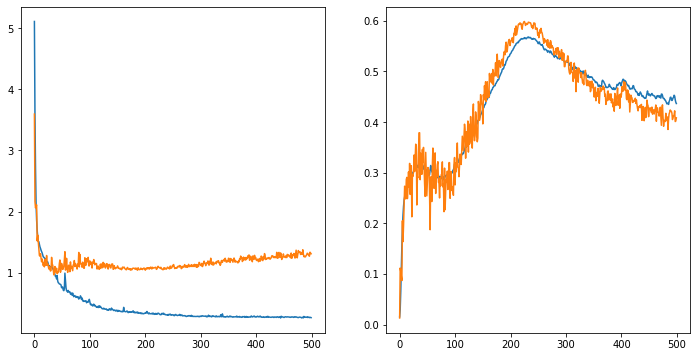

In [44]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[1].plot(hist.history['IoU_metric'])
ax[1].plot(hist.history['val_IoU_metric'])

In [0]:
# from keras.callbacks import TensorBoard
# tb = TensorBoard(log_dir='./log', histogram_freq=1,
#                          write_graph=True,
#                          write_grads=True,
#                          write_images=True)

In [0]:
model.load_weights('cocodogsmall_43_40.h5')

In [0]:
# print(io)

In [0]:
# pred = lab[0]
def plotRectangle(image, y_pred, thresh):
  print(y_pred)
  print(y_pred[:,:, 0])
  max_t = max((y_pred[..., 0]).flatten())
  print('Max: ', max_t)
  s = y_pred.shape                                           
  for i in range(s[0]):
    for j in range(s[1]):
        if y_pred[i][j][0] == max_t:
          max_t = y_pred[i][j][0]
          box = y_pred[i][j][1:]
          print(box)
          (xmi, ymi, xma, yma) = genNot1(box[0], box[1], box[2], box[3], i, j)
          cv2.rectangle(image, (int(xmi), int(ymi)), (int(xma), int(yma)), (0, 0, 255), 1)
  for i in range(0, img_dim, int(img_dim/N)):
    cv2.line(image, (i, 0), (i, img_dim), (255, 0, 0), 1)
  for j in range(0, img_dim, int(img_dim/N)):
    cv2.line(image, (0, j), (img_dim, j), (256, 0, 0), 1)
  cv2_imshow(image)

def genNot1(x, y, h, w, i, j, img_d = img_dim):
  #Return co-ordinates of Bounding Box in clockwise order
  grid_size = (img_dim/float(N))
  real_mp_x = ((x * grid_size) + (i * grid_size))
  real_mp_y = ((y * grid_size) + (j * grid_size))
  print(real_mp_x, real_mp_y)
  real_width = w * grid_size
  real_height = h * grid_size
  xmin = (real_mp_x - real_width/2)
  ymin = (real_mp_y - real_height/2)
  xmax = (real_mp_x + real_width/2)
  ymax = (real_mp_y + real_height/2)
  return (xmin, ymin, xmax, ymax)

In [0]:
image = load_img('1199.jpg', target_size = (img_dim, img_dim))
image = img_to_array(image)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image /= 255.0

[[[0.00000000e+00 6.68032646e-01 3.92192066e-01 1.11679573e+01
   9.58218098e+00]
  [0.00000000e+00 6.68394864e-01 3.94762188e-01 1.10856180e+01
   9.53715897e+00]
  [0.00000000e+00 7.31012464e-01 3.49360049e-01 1.36165104e+01
   1.10463829e+01]
  [0.00000000e+00 6.57913625e-01 4.00451064e-01 1.07278547e+01
   9.32105255e+00]
  [0.00000000e+00 6.83340907e-01 3.82663786e-01 1.17329941e+01
   9.92138481e+00]
  [0.00000000e+00 6.54530823e-01 4.02952850e-01 1.05894461e+01
   9.23858833e+00]
  [0.00000000e+00 6.62249565e-01 3.97253245e-01 1.09048014e+01
   9.42649651e+00]
  [0.00000000e+00 7.16982126e-01 3.57253909e-01 1.31265783e+01
   1.07509708e+01]]

 [[0.00000000e+00 6.84843302e-01 3.80449682e-01 1.18313360e+01
   9.97843552e+00]
  [0.00000000e+00 6.44939065e-01 4.11344975e-01 1.01510859e+01
   8.97929382e+00]
  [2.22765952e-02 5.52284539e-01 4.76211905e-01 6.48462105e+00
   6.78959513e+00]
  [0.00000000e+00 6.04500055e-01 4.39623058e-01 8.55153465e+00
   8.02396488e+00]
  [0.00000000e

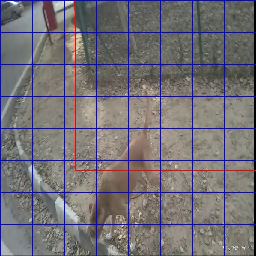

In [66]:
from google.colab.patches import cv2_imshow 
pred = model.predict(np.expand_dims(image, axis = 0))
plotRectangle((image*255), pred[0], 0)
#Required [43, 53, 60, 69]
# print(labels[95])

In [0]:
import matplotlib.pyplot as plt
cv2_imshow(features[14]*255)

In [0]:
###################### TESTING mAP #######################################
Ithresh = 0.4
pr_ls = []
recall = []
final_dict = {}
cthresh = 0.3
for i in range(y_pred.shape[0]):  #For each image
  tp = 0
  fp = 0
  fn = 0
  N = 0
  for j in range(y_pred.shape[1]):
    for k in range(y_pred.shape[2]):
      if (y_pred[i][j][k][0] > cthresh) and (IoU(y_true[i][j][k], y_pred[i][j][k]) > Ithresh):
        N += 1  
      elif (y_pred[i][j][k][0] < cthresh) and (IoU(y_true[i][j][k], y_pred[i][j][k]) > Ithresh):
        fn += 1
  #We have N now, so:
  if N == 0:
    fp += 1
  elif N == 1:
    tp += 1
  elif N > 1:
    tp += 1
    fp += (N - 1)
  prec = tp/ float(tp + fp)
  recall = tp/ float(tp + fn)
  pr_ls.append([prec, recall])
  rec.append(recall)
rec_set = set(recall)
for recall in rec_set:
  pr = 0
  for i in range(len(pr_ls)):
    if (pr_ls[i][0] > pr) and (recall == pr_ls[i][1]):
      final_dict[recall] = pr
AP = sum(final_dict.values())/float(len(final_dict))